In [1]:
# Get required libraries 
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
#Load train and test datasets and shuffle the data 
import time
start = time.clock()
train = shuffle(pd.read_csv("./human-activity-recognition-with-smartphones/train.csv"))
test = shuffle(pd.read_csv("./human-activity-recognition-with-smartphones/test.csv"))

In [3]:
def plot_confusion(classifier, test_pts, test_labels):
    cl = ['STANDING',
               'SITTING',
               'LYING',
               'WALKING',
               'WALK_DOWN',
               'WALK_UP']
    
    pred_label = classifier.predict(test_pts)

    result = confusion_matrix(test_labels, pred_label)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(result)

    fig.colorbar(cax)
    ax.set_xticklabels([''] + cl,rotation = 90)
    ax.set_yticklabels([''] + cl)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [4]:
# Summary statistics of training and test data to check for missing values
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")

#Frequency distribution of classes"
train_outcome = pd.crosstab(index=train["Activity"],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome


Any missing sample in training set: False
Any missing sample in test set: False 



col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


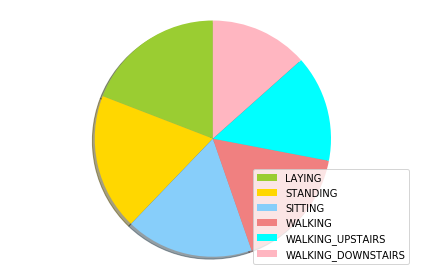

In [5]:
# Visualizing Outcome Distribution 
temp = train["Activity"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()


In [6]:
# Seperating Predictors and Outcome values from train and test sets
X_train = pd.DataFrame(train.drop(['Activity','subject'],axis=1))
Y_train_label = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'],axis=1))
Y_test_label = test.Activity.values.astype(object)

# Dimension of Train and Test set 
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)
#list(set(X_train.columns) - set(num_cols))


names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimension of Train set (7352, 561)
Dimension of Test set (2947, 561) 

Number of numeric features: 561


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)

X_train_scaled = pca.fit_transform(X_train_scaled, Y_train)
print(pca.explained_variance_ratio_.sum())
X_test_scaled = pca.transform(X_test_scaled)

0.9936136011734535


In [8]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4],
                'C': [1, 10, 100]},
               {'kernel': ['linear'], 'C': [1, 10, 100]}]


In [9]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=8)
svm_model.fit(X_train_scaled, Y_train)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.9854461371055495 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[537   0   0   0   0   0]
 [  3 432  55   0   0   1]
 [  0  23 509   0   0   0]
 [  0   0   0 486   4   6]
 [  0   0   0   8 384  28]
 [  0   0   0  15   2 454]]


                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.95      0.88      0.91       491
          STANDING       0.90      0.96      0.93       532
           WALKING       0.95      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.91      0.95       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

       avg / total       0.95      0.95      0.95      2947



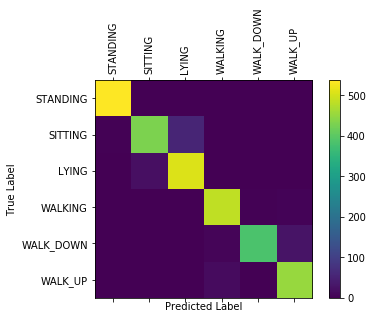

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.950797
Running time: 720.426054 Seconds


In [10]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

# Making the Confusion Matrix

print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))
plot_confusion(final_model,X_test_scaled , Y_test)

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

end = time.clock()
print('Running time: %s Seconds'%(end-start))